In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import iglob
from scipy.spatial.distance import cityblock, cosine

from machine_learning.decomposition import PCA, ICA, LDA
from machine_learning.neighbours import kNN

import sklearn.decomposition
import sklearn.discriminant_analysis

In [2]:
def center(X):
    return X - np.mean(X, axis=0)

In [3]:
def standardize(X):
    return X / np.std(X, axis=0)

In [4]:
def preprocess(X):
    X = center(X)
    return standardize(X)

In [5]:
# Faster than SciPy's Manhattan
def euclidean(a, b):
    return np.linalg.norm(a - b)

In [6]:
# Read image files
def read_images(directory_name):
    X = []; y = []
    for image in iglob("data/" + directory_name + "/*.pgm"):
        face = cv2.resize(plt.imread(image), (50, 60)).flatten()
        X = np.append(X, face)
        y = np.append(y, image.split("/")[2][:5]) # Select the substring in the name that contains the class
    X = np.reshape(X, (-1, 3000))
    return X, y

In [7]:
def results(rank, knn_, X, y):
    true = 0; total = len(X)
    for i in range(total):
        if y[i] in knn_.find_knn(rank, X[i]):
            true += 1
    return round(true / total*100, 2)

# Training

## Population-influenced training

In [8]:
X, y = read_images("training_set")
X = preprocess(X)
Xt = preprocess(np.transpose(X)) # input data for ICA1

In [9]:
# PCA
pca = PCA(n_components=180) # 40% of the number of images
pca.fit(X)
print("The cumulative variance of the first 180 components is " + str(round(pca.explained_variance, 2)) + "%")

The cumulative variance of the first 180 components is 99.66%


In [10]:
# ICA1
pcat = PCA(n_components=180)
pcat.fit(Xt)
ica1 = ICA(n_components=180, method="deflationary")
ica1.fit(np.dot(Xt, pcat.components))

In [11]:
# ICA2
ica2 = ICA(n_components=180, method="deflationary")
ica2.fit(np.dot(X, pca.components))

In [12]:
# LDA
lda = LDA(n_components=180) 
lda.fit(np.dot(X, pca.components), y)

In [13]:
PC = pca.components
IC1 = np.dot(ica1.components, np.transpose(PC))
IC2 = np.dot(ica2.components, np.transpose(PC))
LD = np.dot(lda.components, np.transpose(PC))

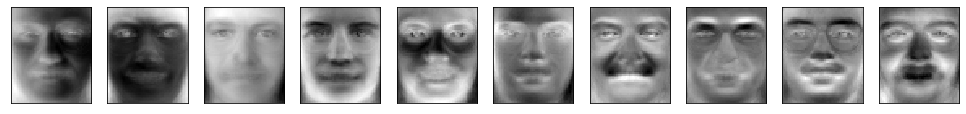

In [14]:
PC_ = np.transpose(PC) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(PC_[i].reshape(60, 50), cmap="gray")

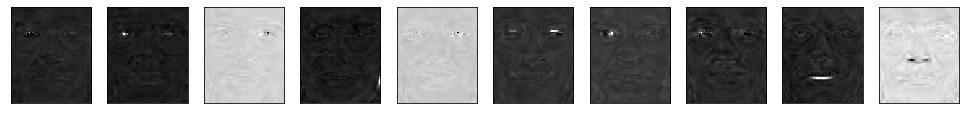

In [15]:
IC1_ = np.dot(ica1.components, np.dot(np.transpose(pcat.components), X)) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC1_[i].reshape(60, 50), cmap="gray")

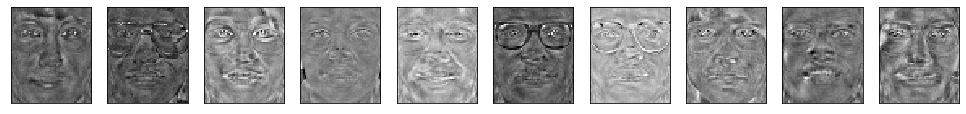

In [16]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC2[i].reshape(60, 50), cmap="gray")

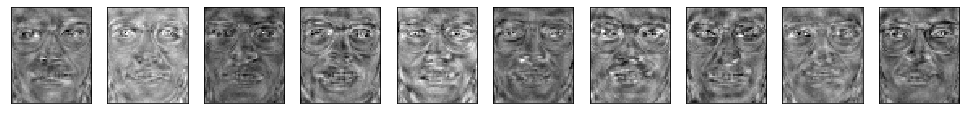

In [17]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(LD[i].reshape(60, 50), cmap="gray")

## Fairness-aware training

In [18]:
Xf, yf = read_images("fair_training_set")
Xf = preprocess(Xf)
Xft = preprocess(np.transpose(Xf)) # input data for ICA1

In [19]:
# PCA
pcaf = PCA(n_components=180) # 40% of the number of images
pcaf.fit(Xf)
print("The cumulative variance of the first 180 components is " + str(round(pcaf.explained_variance, 2)) + "%")

The cumulative variance of the first 180 components is 99.68%


In [20]:
# ICA1
pcaft = PCA(n_components=180)
pcaft.fit(Xft)
ica1f = ICA(n_components=180, method="deflationary")
ica1f.fit(np.dot(Xft, pcaft.components))

In [21]:
# ICA2
ica2f = ICA(n_components=180, method="deflationary")
ica2f.fit(np.dot(Xf, pcaf.components))

In [22]:
# LDA
ldaf = LDA(n_components=180) 
ldaf.fit(np.dot(Xf, pcaf.components), yf)

In [23]:
PCf = pcaf.components
IC1f = np.dot(ica1f.components, np.transpose(PCf))
IC2f = np.dot(ica2f.components, np.transpose(PCf))
LDf = np.dot(ldaf.components, np.transpose(PCf))

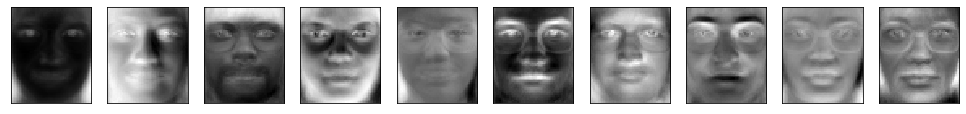

In [24]:
PCf_ = np.transpose(PCf) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(PCf_[i].reshape(60, 50), cmap="gray")

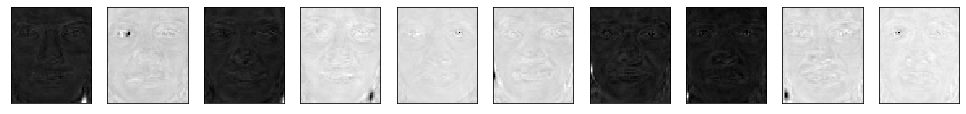

In [25]:
IC1f_ = np.dot(ica1f.components, np.dot(np.transpose(pcaft.components), Xf)) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC1f_[i].reshape(60, 50), cmap="gray")

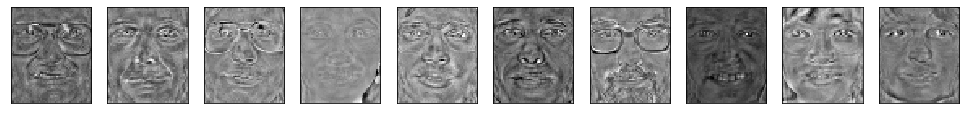

In [26]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC2f[i].reshape(60, 50), cmap="gray")

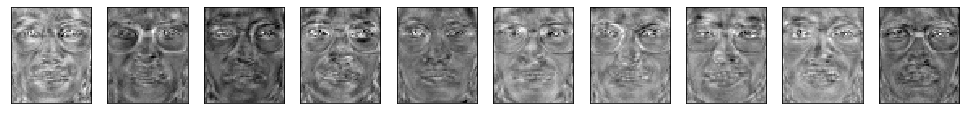

In [27]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(LDf[i].reshape(60, 50), cmap="gray")

# Results

## FERET testing methodology

In [28]:
Xg, yg = read_images("gallery")
Xg = preprocess(Xg)

In [29]:
# FERET gallery set projected on models trained on population-influenced data
Xg_pca = np.dot(Xg, PC)
Xg_ica1 = np.dot(Xg, np.transpose(IC1))
Xg_ica2 = np.dot(Xg, np.transpose(IC2))
Xg_lda = np.dot(Xg, np.transpose(LD))

In [30]:
# FERET gallery set projected on models trained on fairness-aware data
Xg_pcaf = np.dot(Xg, PCf)
Xg_ica1f = np.dot(Xg, np.transpose(IC1f))
Xg_ica2f = np.dot(Xg, np.transpose(IC2f))
Xg_ldaf = np.dot(Xg, np.transpose(LDf))

In [31]:
Xfb, yfb = read_images("fb")
Xfb = preprocess(Xfb)

In [32]:
# FB probe set projected on models trained on population-influenced data
Xfb_pca = np.dot(Xfb, PC)
Xfb_ica1 = np.dot(Xfb, np.transpose(IC1))
Xfb_ica2 = np.dot(Xfb, np.transpose(IC2))
Xfb_lda = np.dot(Xfb, np.transpose(LD))

In [33]:
# FB probe set projected on models trained on fairness-aware data
Xfb_pcaf = np.dot(Xfb, PCf)
Xfb_ica1f = np.dot(Xfb, np.transpose(IC1f))
Xfb_ica2f = np.dot(Xfb, np.transpose(IC2f))
Xfb_ldaf = np.dot(Xfb, np.transpose(LDf))

In [34]:
Xfc, yfc = read_images("fc")
Xfc = preprocess(Xfc)

In [35]:
# FC probe set projected on models trained on population-influenced data
Xfc_pca = np.dot(Xfc, PC)
Xfc_ica1 = np.dot(Xfc, np.transpose(IC1))
Xfc_ica2 = np.dot(Xfc, np.transpose(IC2))
Xfc_lda = np.dot(Xfc, np.transpose(LD))

In [36]:
# FC probe set projected on models trained on fairness-aware data
Xfc_pcaf = np.dot(Xfc, PCf)
Xfc_ica1f = np.dot(Xfc, np.transpose(IC1f))
Xfc_ica2f = np.dot(Xfc, np.transpose(IC2f))
Xfc_ldaf = np.dot(Xfc, np.transpose(LDf))

In [37]:
Xd1, yd1 = read_images("dup1")
Xd1 = preprocess(Xd1)

In [38]:
# DUP1 probe set projected on models trained on population-influenced data
Xd1_pca = np.dot(Xd1, PC)
Xd1_ica1 = np.dot(Xd1, np.transpose(IC1))
Xd1_ica2 = np.dot(Xd1, np.transpose(IC2))
Xd1_lda = np.dot(Xd1, np.transpose(LD))

In [39]:
# DUP1 probe set projected on models trained on fairness-aware data
Xd1_pcaf = np.dot(Xd1, PCf)
Xd1_ica1f = np.dot(Xd1, np.transpose(IC1f))
Xd1_ica2f = np.dot(Xd1, np.transpose(IC2f))
Xd1_ldaf = np.dot(Xd1, np.transpose(LDf))

In [40]:
Xd2, yd2 = read_images("dup2")
Xd2 = preprocess(Xd2)

In [41]:
# DUP2 probe set projected on models trained on population-influenced data
Xd2_pca = np.dot(Xd2, PC)
Xd2_ica1 = np.dot(Xd2, np.transpose(IC1))
Xd2_ica2 = np.dot(Xd2, np.transpose(IC2))
Xd2_lda = np.dot(Xd2, np.transpose(LD))

In [42]:
# DUP2 probe set projected on models trained on fairness-aware data
Xd2_pcaf = np.dot(Xd2, PCf)
Xd2_ica1f = np.dot(Xd2, np.transpose(IC1f))
Xd2_ica2f = np.dot(Xd2, np.transpose(IC2f))
Xd2_ldaf = np.dot(Xd2, np.transpose(LDf))

### kNN training

In [43]:
# kNN trained on the PCA projection of the FERET gallery set trained on population-influenced data
knn_pca_l1 = kNN(Xg_pca, yg, cityblock, 100)
knn_pca_l2 = kNN(Xg_pca, yg, euclidean, 100)
knn_pca_cos = kNN(Xg_pca, yg, cosine, 100)

/Users/ionutdeaconu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  


In [44]:
# kNN trained on the ICA1 projection of the FERET gallery set trained on population-influenced data
knn_ica1_l1 = kNN(Xg_ica1, yg, cityblock, 100)
knn_ica1_l2 = kNN(Xg_ica1, yg, euclidean, 100)
knn_ica1_cos = kNN(Xg_ica1, yg, cosine, 100)

In [45]:
# kNN trained on the ICA2 projection of the FERET gallery set trained on population-influenced data
knn_ica2_l1 = kNN(Xg_ica2, yg, cityblock, 100)
knn_ica2_l2 = kNN(Xg_ica2, yg, euclidean, 100)
knn_ica2_cos = kNN(Xg_ica2, yg, cosine, 100)

In [46]:
# kNN trained on the LDA projection of the FERET gallery set trained on population-influenced data
knn_lda_l1 = kNN(Xg_lda, yg, cityblock, 100)
knn_lda_l2 = kNN(Xg_lda, yg, euclidean, 100)
knn_lda_cos = kNN(Xg_lda, yg, cosine, 100)

In [47]:
# kNN trained on the PCA projection of the FERET gallery set trained on fairness-aware data
knn_pcaf_l1 = kNN(Xg_pcaf, yg, cityblock, 100)
knn_pcaf_l2 = kNN(Xg_pcaf, yg, euclidean, 100)
knn_pcaf_cos = kNN(Xg_pcaf, yg, cosine, 100)

In [48]:
# kNN trained on the ICA1 projection of the FERET gallery set trained on fairness-aware data
knn_ica1f_l1 = kNN(Xg_ica1f, yg, cityblock, 100)
knn_ica1f_l2 = kNN(Xg_ica1f, yg, euclidean, 100)
knn_ica1f_cos = kNN(Xg_ica1f, yg, cosine, 100)

In [49]:
# kNN trained on the ICA2 projection of the FERET gallery set trained on fairness-aware data
knn_ica2f_l1 = kNN(Xg_ica2f, yg, cityblock, 100)
knn_ica2f_l2 = kNN(Xg_ica2f, yg, euclidean, 100)
knn_ica2f_cos = kNN(Xg_ica2f, yg, cosine, 100)

In [50]:
# kNN trained on the LDA projection of the FERET gallery set trained on fairness-aware data
knn_ldaf_l1 = kNN(Xg_ldaf, yg, cityblock, 100)
knn_ldaf_l2 = kNN(Xg_ldaf, yg, euclidean, 100)
knn_ldaf_cos = kNN(Xg_ldaf, yg, cosine, 100)

### FERET testing

#### Population-influenced data

##### FB probe set

In [51]:
print("Results on the FB probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pca_l1, Xfb_pca, yfb)))
print("L2: " + str(results(1, knn_pca_l2, Xfb_pca, yfb)))
print("COS: " + str(results(1, knn_pca_cos, Xfb_pca, yfb)))

Results on the FB probe set for the PCA projection of the FERET gallery set:
L1: 72.97
L2: 74.06
COS: 76.07


In [52]:
print("Results on the FB probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1_l1, Xfb_ica1, yfb)))
print("L2: " + str(results(1, knn_ica1_l2, Xfb_ica1, yfb)))
print("COS: " + str(results(1, knn_ica1_cos, Xfb_ica1, yfb)))

Results on the FB probe set for the ICA1 projection of the FERET gallery set:
L1: 61.76
L2: 62.76
COS: 76.57


In [53]:
print("Results on the FB probe set for the ICA2 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2_l1, Xfb_ica2, yfb)))
print("L2: " + str(results(1, knn_ica2_l2, Xfb_ica2, yfb)))
print("COS: " + str(results(1, knn_ica2_cos, Xfb_ica2, yfb)))

Results on the FB probe set for the ICA2 projection of the FERET gallery set:
L1: 61.17
L2: 62.76
COS: 76.4


In [54]:
print("Results on the FB probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_lda_l1, Xfb_lda, yfb)))
print("L2: " + str(results(1, knn_lda_l2, Xfb_lda, yfb)))
print("COS: " + str(results(1, knn_lda_cos, Xfb_lda, yfb)))

Results on the FB probe set for the LDA projection of the FERET gallery set:
L1: 76.65
L2: 74.06
COS: 76.07


##### FC probe set

In [55]:
print("Results on the FC probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pca_l1, Xfc_pca, yfc)))
print("L2: " + str(results(1, knn_pca_l2, Xfc_pca, yfc)))
print("COS: " + str(results(1, knn_pca_cos, Xfc_pca, yfc)))

Results on the FC probe set for the PCA projection of the FERET gallery set:
L1: 71.65
L2: 55.15
COS: 50.52


In [56]:
print("Results on the FC probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1_l1, Xfc_ica1, yfc)))
print("L2: " + str(results(1, knn_ica1_l2, Xfc_ica1, yfc)))
print("COS: " + str(results(1, knn_ica1_cos, Xfc_ica1, yfc)))

Results on the FC probe set for the ICA1 projection of the FERET gallery set:
L1: 64.95
L2: 67.01
COS: 75.26


In [57]:
print("Results on the FC probe set for the ICA2 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2_l1, Xfc_ica2, yfc)))
print("L2: " + str(results(1, knn_ica2_l2, Xfc_ica2, yfc)))
print("COS: " + str(results(1, knn_ica2_cos, Xfc_ica2, yfc)))

Results on the FC probe set for the ICA2 projection of the FERET gallery set:
L1: 62.37
L2: 66.49
COS: 74.74


In [58]:
print("Results on the FC probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_lda_l1, Xfc_lda, yfc)))
print("L2: " + str(results(1, knn_lda_l2, Xfc_lda, yfc)))
print("COS: " + str(results(1, knn_lda_cos, Xfc_lda, yfc)))

Results on the FC probe set for the LDA projection of the FERET gallery set:
L1: 60.82
L2: 55.15
COS: 50.52


##### DUP1 probe set

In [59]:
print("Results on the DUP1 probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pca_l1, Xd1_pca, yd1)))
print("L2: " + str(results(1, knn_pca_l2, Xd1_pca, yd1)))
print("COS: " + str(results(1, knn_pca_cos, Xd1_pca, yd1)))

Results on the DUP1 probe set for the PCA projection of the FERET gallery set:
L1: 32.13
L2: 29.78
COS: 32.55


In [60]:
print("Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1_l1, Xd1_ica1, yd1)))
print("L2: " + str(results(1, knn_ica1_l2, Xd1_ica1, yd1)))
print("COS: " + str(results(1, knn_ica1_cos, Xd1_ica1, yd1)))

Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:
L1: 24.65
L2: 25.48
COS: 41.83


In [61]:
print("Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2_l1, Xd1_ica2, yd1)))
print("L2: " + str(results(1, knn_ica2_l2, Xd1_ica2, yd1)))
print("COS: " + str(results(1, knn_ica2_cos, Xd1_ica2, yd1)))

Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:
L1: 20.22
L2: 25.62
COS: 41.69


In [62]:
print("Results on the DUP1 probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_lda_l1, Xd1_lda, yd1)))
print("L2: " + str(results(1, knn_lda_l2, Xd1_lda, yd1)))
print("COS: " + str(results(1, knn_lda_cos, Xd1_lda, yd1)))

Results on the DUP1 probe set for the LDA projection of the FERET gallery set:
L1: 35.6
L2: 29.78
COS: 32.55


##### DUP2 probe set

In [63]:
print("Results on the DUP2 probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pca_l1, Xd2_pca, yd2)))
print("L2: " + str(results(1, knn_pca_l2, Xd2_pca, yd2)))
print("COS: " + str(results(1, knn_pca_cos, Xd2_pca, yd2)))

Results on the DUP2 probe set for the PCA projection of the FERET gallery set:
L1: 20.94
L2: 19.23
COS: 23.93


In [64]:
print("Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1_l1, Xd2_ica1, yd2)))
print("L2: " + str(results(1, knn_ica1_l2, Xd2_ica1, yd2)))
print("COS: " + str(results(1, knn_ica1_cos, Xd2_ica1, yd2)))

Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:
L1: 16.67
L2: 15.38
COS: 37.61


In [65]:
print("Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2_l1, Xd2_ica2, yd2)))
print("L2: " + str(results(1, knn_ica2_l2, Xd2_ica2, yd2)))
print("COS: " + str(results(1, knn_ica2_cos, Xd2_ica2, yd2)))

Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:
L1: 12.39
L2: 14.96
COS: 36.75


In [66]:
print("Results on the DUP2 probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_lda_l1, Xd2_lda, yd2)))
print("L2: " + str(results(1, knn_lda_l2, Xd2_lda, yd2)))
print("COS: " + str(results(1, knn_lda_cos, Xd2_lda, yd2)))

Results on the DUP2 probe set for the LDA projection of the FERET gallery set:
L1: 27.35
L2: 19.23
COS: 23.93


#### Fairness-aware data

##### FB probe set

In [67]:
print("Results on the FB probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1, Xfb_pcaf, yfb)))
print("L2: " + str(results(1, knn_pcaf_l2, Xfb_pcaf, yfb)))
print("COS: " + str(results(1, knn_pcaf_cos, Xfb_pcaf, yfb)))

Results on the FB probe set for the PCA projection of the FERET gallery set:
L1: 72.13
L2: 72.8
COS: 75.48


In [68]:
print("Results on the FB probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1, Xfb_ica1f, yfb)))
print("L2: " + str(results(1, knn_ica1f_l2, Xfb_ica1f, yfb)))
print("COS: " + str(results(1, knn_ica1f_cos, Xfb_ica1f, yfb)))

Results on the FB probe set for the ICA1 projection of the FERET gallery set:
L1: 60.42
L2: 61.51
COS: 74.73


In [69]:
print("Results on the FB probe set for the ICA2 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1, Xfb_ica2f, yfb)))
print("L2: " + str(results(1, knn_ica2f_l2, Xfb_ica2f, yfb)))
print("COS: " + str(results(1, knn_ica2f_cos, Xfb_ica2f, yfb)))

Results on the FB probe set for the ICA2 projection of the FERET gallery set:
L1: 58.74
L2: 60.75
COS: 74.56


In [70]:
print("Results on the FB probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1, Xfb_ldaf, yfb)))
print("L2: " + str(results(1, knn_ldaf_l2, Xfb_ldaf, yfb)))
print("COS: " + str(results(1, knn_ldaf_cos, Xfb_ldaf, yfb)))

Results on the FB probe set for the LDA projection of the FERET gallery set:
L1: 79.0
L2: 72.8
COS: 75.48


##### FC probe set

In [71]:
print("Results on the FC probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1, Xfc_pcaf, yfc)))
print("L2: " + str(results(1, knn_pcaf_l2, Xfc_pcaf, yfc)))
print("COS: " + str(results(1, knn_pcaf_cos, Xfc_pcaf, yfc)))

Results on the FC probe set for the PCA projection of the FERET gallery set:
L1: 67.01
L2: 53.09
COS: 47.42


In [72]:
print("Results on the FC probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1, Xfc_ica1f, yfc)))
print("L2: " + str(results(1, knn_ica1f_l2, Xfc_ica1f, yfc)))
print("COS: " + str(results(1, knn_ica1f_cos, Xfc_ica1f, yfc)))

Results on the FC probe set for the ICA1 projection of the FERET gallery set:
L1: 60.82
L2: 61.34
COS: 70.62


In [73]:
print("Results on the FC probe set for the ICA2 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1, Xfc_ica2f, yfc)))
print("L2: " + str(results(1, knn_ica2f_l2, Xfc_ica2f, yfc)))
print("COS: " + str(results(1, knn_ica2f_cos, Xfc_ica2f, yfc)))

Results on the FC probe set for the ICA2 projection of the FERET gallery set:
L1: 59.79
L2: 60.82
COS: 70.1


In [74]:
print("Results on the FC probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1, Xfc_ldaf, yfc)))
print("L2: " + str(results(1, knn_ldaf_l2, Xfc_ldaf, yfc)))
print("COS: " + str(results(1, knn_ldaf_cos, Xfc_ldaf, yfc)))

Results on the FC probe set for the LDA projection of the FERET gallery set:
L1: 60.31
L2: 53.09
COS: 47.42


##### DUP1 probe set

In [75]:
print("Results on the DUP1 probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1, Xd1_pcaf, yd1)))
print("L2: " + str(results(1, knn_pcaf_l2, Xd1_pcaf, yd1)))
print("COS: " + str(results(1, knn_pcaf_cos, Xd1_pcaf, yd1)))

Results on the DUP1 probe set for the PCA projection of the FERET gallery set:
L1: 32.69
L2: 28.81
COS: 30.75


In [76]:
print("Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1, Xd1_ica1f, yd1)))
print("L2: " + str(results(1, knn_ica1f_l2, Xd1_ica1f, yd1)))
print("COS: " + str(results(1, knn_ica1f_cos, Xd1_ica1f, yd1)))

Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:
L1: 29.09
L2: 30.47
COS: 42.38


In [77]:
print("Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1, Xd1_ica2f, yd1)))
print("L2: " + str(results(1, knn_ica2f_l2, Xd1_ica2f, yd1)))
print("COS: " + str(results(1, knn_ica2f_cos, Xd1_ica2f, yd1)))

Results on the DUP1 probe set for the ICA1 projection of the FERET gallery set:
L1: 28.12
L2: 29.92
COS: 41.97


In [78]:
print("Results on the DUP1 probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1, Xd1_ldaf, yd1)))
print("L2: " + str(results(1, knn_ldaf_l2, Xd1_ldaf, yd1)))
print("COS: " + str(results(1, knn_ldaf_cos, Xd1_ldaf, yd1)))

Results on the DUP1 probe set for the LDA projection of the FERET gallery set:
L1: 32.55
L2: 28.81
COS: 30.75


##### DUP2 probe set

In [79]:
print("Results on the DUP2 probe set for the PCA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1, Xd2_pcaf, yd2)))
print("L2: " + str(results(1, knn_pcaf_l2, Xd2_pcaf, yd2)))
print("COS: " + str(results(1, knn_pcaf_cos, Xd2_pcaf, yd2)))

Results on the DUP2 probe set for the PCA projection of the FERET gallery set:
L1: 22.65
L2: 19.23
COS: 22.65


In [80]:
print("Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1, Xd2_ica1f, yd2)))
print("L2: " + str(results(1, knn_ica1f_l2, Xd2_ica1f, yd2)))
print("COS: " + str(results(1, knn_ica1f_cos, Xd2_ica1f, yd2)))

Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:
L1: 18.38
L2: 19.23
COS: 39.32


In [81]:
print("Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1, Xd2_ica2f, yd2)))
print("L2: " + str(results(1, knn_ica2f_l2, Xd2_ica2f, yd2)))
print("COS: " + str(results(1, knn_ica2f_cos, Xd2_ica2f, yd2)))

Results on the DUP2 probe set for the ICA1 projection of the FERET gallery set:
L1: 17.09
L2: 19.66
COS: 38.89


In [82]:
print("Results on the DUP2 probe set for the LDA projection of the FERET gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1, Xd2_ldaf, yd2)))
print("L2: " + str(results(1, knn_ldaf_l2, Xd2_ldaf, yd2)))
print("COS: " + str(results(1, knn_ldaf_cos, Xd2_ldaf, yd2)))

Results on the DUP2 probe set for the LDA projection of the FERET gallery set:
L1: 23.5
L2: 19.23
COS: 22.65


## Fairness testing methodology

In [83]:
Xfg, yfg = read_images("fair_gallery")
Xfg = preprocess(Xfg)

In [84]:
# Fair gallery set projected on models trained on population-influenced data
Xfg_pca = np.dot(Xfg, PC)
Xfg_ica1 = np.dot(Xfg, np.transpose(IC1))
Xfg_ica2 = np.dot(Xfg, np.transpose(IC2))
Xfg_lda = np.dot(Xfg, np.transpose(LD))

In [85]:
# Fair gallery set projected on models trained on fairness-aware data
Xfg_pcaf = np.dot(Xfg, PCf)
Xfg_ica1f = np.dot(Xfg, np.transpose(IC1f))
Xfg_ica2f = np.dot(Xfg, np.transpose(IC2f))
Xfg_ldaf = np.dot(Xfg, np.transpose(LDf))

In [86]:
Xcg, ycg = read_images("caucasian_gallery")
Xcg = preprocess(Xcg)

In [87]:
# Caucasian gallery set projected on models trained on population-influenced data
Xcg_pca = np.dot(Xcg, PC)
Xcg_ica1 = np.dot(Xcg, np.transpose(IC1))
Xcg_ica2 = np.dot(Xcg, np.transpose(IC2))
Xcg_lda = np.dot(Xcg, np.transpose(LD))

In [88]:
# Caucasian gallery set projected on models trained on fairness-aware data
Xcg_pcaf = np.dot(Xcg, PCf)
Xcg_ica1f = np.dot(Xcg, np.transpose(IC1f))
Xcg_ica2f = np.dot(Xcg, np.transpose(IC2f))
Xcg_ldaf = np.dot(Xcg, np.transpose(LDf))

In [89]:
Xag, yag = read_images("african_gallery")
Xag = preprocess(Xag)

In [90]:
# African gallery set projected on models trained on population-influenced data
Xag_pca = np.dot(Xag, PC)
Xag_ica1 = np.dot(Xag, np.transpose(IC1))
Xag_ica2 = np.dot(Xag, np.transpose(IC2))
Xag_lda = np.dot(Xag, np.transpose(LD))

In [91]:
# African gallery set projected on models trained on fairness-aware data
Xag_pcaf = np.dot(Xag, PCf)
Xag_ica1f = np.dot(Xag, np.transpose(IC1f))
Xag_ica2f = np.dot(Xag, np.transpose(IC2f))
Xag_ldaf = np.dot(Xag, np.transpose(LDf))

In [92]:
Xseg, yseg = read_images("SE_asian_gallery")
Xseg = preprocess(Xseg)

In [93]:
# South-East Asian gallery set projected on models trained on population-influenced data
Xseg_pca = np.dot(Xseg, PC)
Xseg_ica1 = np.dot(Xseg, np.transpose(IC1))
Xseg_ica2 = np.dot(Xseg, np.transpose(IC2))
Xseg_lda = np.dot(Xseg, np.transpose(LD))

In [94]:
# South-East Asian gallery set projected on models trained on fairness-aware data
Xseg_pcaf = np.dot(Xseg, PCf)
Xseg_ica1f = np.dot(Xseg, np.transpose(IC1f))
Xseg_ica2f = np.dot(Xseg, np.transpose(IC2f))
Xseg_ldaf = np.dot(Xseg, np.transpose(LDf))

In [95]:
Xfp, yfp = read_images("fair_probe")
Xfp = preprocess(Xfp)

In [96]:
# Fair probe set projected on models trained on population-influenced data
Xfp_pca = np.dot(Xfp, PC)
Xfp_ica1 = np.dot(Xfp, np.transpose(IC1))
Xfp_ica2 = np.dot(Xfp, np.transpose(IC2))
Xfp_lda = np.dot(Xfp, np.transpose(LD))

In [97]:
# Fair probe set projected on models trained on fairness-aware data
Xfp_pcaf = np.dot(Xfp, PCf)
Xfp_ica1f = np.dot(Xfp, np.transpose(IC1f))
Xfp_ica2f = np.dot(Xfp, np.transpose(IC2f))
Xfp_ldaf = np.dot(Xfp, np.transpose(LDf))

In [98]:
Xcp, ycp = read_images("caucasian_probe")
Xcp = preprocess(Xcp)

In [99]:
# Caucasian probe set projected on models trained on population-influenced data
Xcp_pca = np.dot(Xcp, PC)
Xcp_ica1 = np.dot(Xcp, np.transpose(IC1))
Xcp_ica2 = np.dot(Xcp, np.transpose(IC2))
Xcp_lda = np.dot(Xcp, np.transpose(LD))

In [100]:
# Caucasian probe set projected on models trained on fairness-aware data
Xcp_pcaf = np.dot(Xcp, PCf)
Xcp_ica1f = np.dot(Xcp, np.transpose(IC1f))
Xcp_ica2f = np.dot(Xcp, np.transpose(IC2f))
Xcp_ldaf = np.dot(Xcp, np.transpose(LDf))

In [101]:
Xap, yap = read_images("african_probe")
Xap = preprocess(Xap)

In [102]:
# African probe set projected on models trained on population-influenced data
Xap_pca = np.dot(Xap, PC)
Xap_ica1 = np.dot(Xap, np.transpose(IC1))
Xap_ica2 = np.dot(Xap, np.transpose(IC2))
Xap_lda = np.dot(Xap, np.transpose(LD))

In [103]:
# African probe set projected on models trained on fairness-aware data
Xap_pcaf = np.dot(Xap, PCf)
Xap_ica1f = np.dot(Xap, np.transpose(IC1f))
Xap_ica2f = np.dot(Xap, np.transpose(IC2f))
Xap_ldaf = np.dot(Xap, np.transpose(LDf))

In [104]:
Xsep, ysep = read_images("SE_asian_probe")
Xsep = preprocess(Xsep)

In [105]:
# South-East Asian probe set projected on models trained on population-influenced data
Xsep_pca = np.dot(Xsep, PC)
Xsep_ica1 = np.dot(Xsep, np.transpose(IC1))
Xsep_ica2 = np.dot(Xsep, np.transpose(IC2))
Xsep_lda = np.dot(Xsep, np.transpose(LD))

In [106]:
# South-East Asian probe set projected on models trained on fairness-aware data
Xsep_pcaf = np.dot(Xsep, PCf)
Xsep_ica1f = np.dot(Xsep, np.transpose(IC1f))
Xsep_ica2f = np.dot(Xsep, np.transpose(IC2f))
Xsep_ldaf = np.dot(Xsep, np.transpose(LDf))

### kNN training

In [107]:
# kNN trained on the PCA projection of the fair gallery set trained on population-influenced data
knn_pca_l1_ = kNN(Xfg_pca, yfg, cityblock, 100)
knn_pca_l2_ = kNN(Xfg_pca, yfg, euclidean, 100)
knn_pca_cos_ = kNN(Xfg_pca, yfg, cosine, 100)

In [108]:
# kNN trained on the PCA projection of the Caucasian gallery set trained on population-influenced data
knn_pca_l1_c = kNN(Xcg_pca, ycg, cityblock, 100)
knn_pca_l2_c = kNN(Xcg_pca, ycg, euclidean, 100)
knn_pca_cos_c = kNN(Xcg_pca, ycg, cosine, 100)

In [109]:
# kNN trained on the PCA projection of the African gallery set trained on population-influenced data
knn_pca_l1_a = kNN(Xag_pca, yag, cityblock, 100)
knn_pca_l2_a = kNN(Xag_pca, yag, euclidean, 100)
knn_pca_cos_a = kNN(Xag_pca, yag, cosine, 100)

In [110]:
# kNN trained on the PCA projection of the South-East Asian gallery set trained on population-influenced data
knn_pca_l1_se = kNN(Xseg_pca, yseg, cityblock, 100)
knn_pca_l2_se = kNN(Xseg_pca, yseg, euclidean, 100)
knn_pca_cos_se = kNN(Xseg_pca, yseg, cosine, 100)

In [111]:
# kNN trained on the ICA1 projection of the fair gallery set trained on population-influenced data
knn_ica1_l1_ = kNN(Xfg_ica1, yfg, cityblock, 100)
knn_ica1_l2_ = kNN(Xfg_ica1, yfg, euclidean, 100)
knn_ica1_cos_ = kNN(Xfg_ica1, yfg, cosine, 100)

In [112]:
# kNN trained on the ICA1 projection of the Caucasian gallery set trained on population-influenced data
knn_ica1_l1_c = kNN(Xcg_ica1, ycg, cityblock, 100)
knn_ica1_l2_c = kNN(Xcg_ica1, ycg, euclidean, 100)
knn_ica1_cos_c = kNN(Xcg_ica1, ycg, cosine, 100)

In [113]:
# kNN trained on the ICA1 projection of the African gallery set trained on population-influenced data
knn_ica1_l1_a = kNN(Xag_ica1, yag, cityblock, 100)
knn_ica1_l2_a = kNN(Xag_ica1, yag, euclidean, 100)
knn_ica1_cos_a = kNN(Xag_ica1, yag, cosine, 100)

In [114]:
# kNN trained on the ICA1 projection of the South-East Asian gallery set trained on population-influenced data
knn_ica1_l1_se = kNN(Xseg_ica1, yseg, cityblock, 100)
knn_ica1_l2_se = kNN(Xseg_ica1, yseg, euclidean, 100)
knn_ica1_cos_se = kNN(Xseg_ica1, yseg, cosine, 100)

In [115]:
# kNN trained on the ICA2 projection of the fair gallery set trained on population-influenced data
knn_ica2_l1_ = kNN(Xfg_ica2, yfg, cityblock, 100)
knn_ica2_l2_ = kNN(Xfg_ica2, yfg, euclidean, 100)
knn_ica2_cos_ = kNN(Xfg_ica2, yfg, cosine, 100)

In [116]:
# kNN trained on the ICA2 projection of the Caucasian gallery set trained on population-influenced data
knn_ica2_l1_c = kNN(Xcg_ica2, ycg, cityblock, 100)
knn_ica2_l2_c = kNN(Xcg_ica2, ycg, euclidean, 100)
knn_ica2_cos_c = kNN(Xcg_ica2, ycg, cosine, 100)

In [117]:
# kNN trained on the ICA2 projection of the African gallery set trained on population-influenced data
knn_ica2_l1_a = kNN(Xag_ica2, yag, cityblock, 100)
knn_ica2_l2_a = kNN(Xag_ica2, yag, euclidean, 100)
knn_ica2_cos_a = kNN(Xag_ica2, yag, cosine, 100)

In [118]:
# kNN trained on the ICA2 projection of the South-East Asian gallery set trained on population-influenced data
knn_ica2_l1_se = kNN(Xseg_ica2, yseg, cityblock, 100)
knn_ica2_l2_se = kNN(Xseg_ica2, yseg, euclidean, 100)
knn_ica2_cos_se = kNN(Xseg_ica2, yseg, cosine, 100)

In [119]:
# kNN trained on the LDA projection of the fair gallery set trained on population-influenced data
knn_lda_l1_ = kNN(Xfg_lda, yfg, cityblock, 100)
knn_lda_l2_ = kNN(Xfg_lda, yfg, euclidean, 100)
knn_lda_cos_ = kNN(Xfg_lda, yfg, cosine, 100)

In [120]:
# kNN trained on the LDA projection of the Caucasian gallery set trained on population-influenced data
knn_lda_l1_c = kNN(Xcg_lda, ycg, cityblock, 100)
knn_lda_l2_c = kNN(Xcg_lda, ycg, euclidean, 100)
knn_lda_cos_c = kNN(Xcg_lda, ycg, cosine, 100)

In [121]:
# kNN trained on the LDA projection of the African gallery set trained on population-influenced data
knn_lda_l1_a = kNN(Xag_lda, yag, cityblock, 100)
knn_lda_l2_a = kNN(Xag_lda, yag, euclidean, 100)
knn_lda_cos_a = kNN(Xag_lda, yag, cosine, 100)

In [122]:
# kNN trained on the LDA projection of the South-East Asian gallery set trained on population-influenced data
knn_lda_l1_se = kNN(Xseg_lda, yseg, cityblock, 100)
knn_lda_l2_se = kNN(Xseg_lda, yseg, euclidean, 100)
knn_lda_cos_se = kNN(Xseg_lda, yseg, cosine, 100)

In [123]:
# kNN trained on the PCA projection of the fair gallery set trained on fairness-aware data
knn_pcaf_l1_ = kNN(Xfg_pcaf, yfg, cityblock, 100)
knn_pcaf_l2_ = kNN(Xfg_pcaf, yfg, euclidean, 100)
knn_pcaf_cos_ = kNN(Xfg_pcaf, yfg, cosine, 100)

In [124]:
# kNN trained on the PCA projection of the Caucasian gallery set trained on fairness-aware data
knn_pcaf_l1_c = kNN(Xcg_pcaf, ycg, cityblock, 100)
knn_pcaf_l2_c = kNN(Xcg_pcaf, ycg, euclidean, 100)
knn_pcaf_cos_c = kNN(Xcg_pcaf, ycg, cosine, 100)

In [125]:
# kNN trained on the PCA projection of the African gallery set trained on fairness-aware data
knn_pcaf_l1_a = kNN(Xag_pcaf, yag, cityblock, 100)
knn_pcaf_l2_a = kNN(Xag_pcaf, yag, euclidean, 100)
knn_pcaf_cos_a = kNN(Xag_pcaf, yag, cosine, 100)

In [126]:
# kNN trained on the PCA projection of the South-East Asian gallery set trained on fairness-aware data
knn_pcaf_l1_se = kNN(Xseg_pcaf, yseg, cityblock, 100)
knn_pcaf_l2_se = kNN(Xseg_pcaf, yseg, euclidean, 100)
knn_pcaf_cos_se = kNN(Xseg_pcaf, yseg, cosine, 100)

In [127]:
# kNN trained on the ICA1 projection of the fair gallery set trained on fairness-aware data
knn_ica1f_l1_ = kNN(Xfg_ica1f, yfg, cityblock, 100)
knn_ica1f_l2_ = kNN(Xfg_ica1f, yfg, euclidean, 100)
knn_ica1f_cos_ = kNN(Xfg_ica1f, yfg, cosine, 100)

In [128]:
# kNN trained on the ICA1 projection of the Caucasian gallery set trained on fairness-aware data
knn_ica1f_l1_c = kNN(Xcg_ica1f, ycg, cityblock, 100)
knn_ica1f_l2_c = kNN(Xcg_ica1f, ycg, euclidean, 100)
knn_ica1f_cos_c = kNN(Xcg_ica1f, ycg, cosine, 100)

In [129]:
# kNN trained on the ICA1 projection of the African gallery set trained on fairness-aware data
knn_ica1f_l1_a = kNN(Xag_ica1f, yag, cityblock, 100)
knn_ica1f_l2_a = kNN(Xag_ica1f, yag, euclidean, 100)
knn_ica1f_cos_a = kNN(Xag_ica1f, yag, cosine, 100)

In [130]:
# kNN trained on the ICA1 projection of the South-East Asian gallery set trained on fairness-aware data
knn_ica1f_l1_se = kNN(Xseg_ica1f, yseg, cityblock, 100)
knn_ica1f_l2_se = kNN(Xseg_ica1f, yseg, euclidean, 100)
knn_ica1f_cos_se = kNN(Xseg_ica1f, yseg, cosine, 100)

In [131]:
# kNN trained on the ICA2 projection of the fair gallery set trained on fairness-aware data
knn_ica2f_l1_ = kNN(Xfg_ica2f, yfg, cityblock, 100)
knn_ica2f_l2_ = kNN(Xfg_ica2f, yfg, euclidean, 100)
knn_ica2f_cos_ = kNN(Xfg_ica2f, yfg, cosine, 100)

In [132]:
# kNN trained on the ICA2 projection of the Caucasian gallery set trained on fairness-aware data
knn_ica2f_l1_c = kNN(Xcg_ica2f, ycg, cityblock, 100)
knn_ica2f_l2_c = kNN(Xcg_ica2f, ycg, euclidean, 100)
knn_ica2f_cos_c = kNN(Xcg_ica2f, ycg, cosine, 100)

In [133]:
# kNN trained on the ICA2 projection of the African gallery set trained on fairness-aware data
knn_ica2f_l1_a = kNN(Xag_ica2f, yag, cityblock, 100)
knn_ica2f_l2_a = kNN(Xag_ica2f, yag, euclidean, 100)
knn_ica2f_cos_a = kNN(Xag_ica2f, yag, cosine, 100)

In [134]:
# kNN trained on the ICA2 projection of the South-East Asian gallery set trained on fairness-aware data
knn_ica2f_l1_se = kNN(Xseg_ica2f, yseg, cityblock, 100)
knn_ica2f_l2_se = kNN(Xseg_ica2f, yseg, euclidean, 100)
knn_ica2f_cos_se = kNN(Xseg_ica2f, yseg, cosine, 100)

In [135]:
# kNN trained on the LDA projection of the fair gallery set trained on fairness-aware data
knn_ldaf_l1_ = kNN(Xfg_ldaf, yfg, cityblock, 100)
knn_ldaf_l2_ = kNN(Xfg_ldaf, yfg, euclidean, 100)
knn_ldaf_cos_ = kNN(Xfg_ldaf, yfg, cosine, 100)

In [136]:
# kNN trained on the LDA projection of the Caucasian gallery set trained on fairness-aware data
knn_ldaf_l1_c = kNN(Xcg_ldaf, ycg, cityblock, 100)
knn_ldaf_l2_c = kNN(Xcg_ldaf, ycg, euclidean, 100)
knn_ldaf_cos_c = kNN(Xcg_ldaf, ycg, cosine, 100)

In [137]:
# kNN trained on the LDA projection of the African gallery set trained on fairness-aware data
knn_ldaf_l1_a = kNN(Xag_ldaf, yag, cityblock, 100)
knn_ldaf_l2_a = kNN(Xag_ldaf, yag, euclidean, 100)
knn_ldaf_cos_a = kNN(Xag_ldaf, yag, cosine, 100)

In [138]:
# kNN trained on the LDA projection of the South-East Asian gallery set trained on fairness-aware data
knn_ldaf_l1_se = kNN(Xseg_ldaf, yseg, cityblock, 100)
knn_ldaf_l2_se = kNN(Xseg_ldaf, yseg, euclidean, 100)
knn_ldaf_cos_se = kNN(Xseg_ldaf, yseg, cosine, 100)

### Fairness testing

#### Population-influenced data

In [139]:
print("Results on the fair probe set for the PCA projection of the fair gallery set:")
print("L1: " + str(results(1, knn_pca_l1_, Xfp_pca, yfp)))
print("L2: " + str(results(1, knn_pca_l2_, Xfp_pca, yfp)))
print("COS: " + str(results(1, knn_pca_cos_, Xfp_pca, yfp)))

Results on the fair probe set for the PCA projection of the fair gallery set:
L1: 77.33
L2: 76.67
COS: 78.0


In [140]:
print("Results on the fair probe set for the ICA1 projection of the fair gallery set:")
print("L1: " + str(results(1, knn_ica1_l1_, Xfp_ica1, yfp)))
print("L2: " + str(results(1, knn_ica1_l2_, Xfp_ica1, yfp)))
print("COS: " + str(results(1, knn_ica1_cos_, Xfp_ica1, yfp)))

Results on the fair probe set for the ICA1 projection of the fair gallery set:
L1: 68.67
L2: 69.33
COS: 80.67


In [141]:
print("Results on the fair probe set for the ICA2 projection of the fair gallery set:")
print("L1: " + str(results(1, knn_ica2_l1_, Xfp_ica2, yfp)))
print("L2: " + str(results(1, knn_ica2_l2_, Xfp_ica2, yfp)))
print("COS: " + str(results(1, knn_ica2_cos_, Xfp_ica2, yfp)))

Results on the fair probe set for the ICA2 projection of the fair gallery set:
L1: 68.67
L2: 69.33
COS: 80.67


In [142]:
print("Results on the fair probe set for the LDA projection of the fair gallery set:")
print("L1: " + str(results(1, knn_lda_l1_, Xfp_lda, yfp)))
print("L2: " + str(results(1, knn_lda_l2_, Xfp_lda, yfp)))
print("COS: " + str(results(1, knn_lda_cos_, Xfp_lda, yfp)))

Results on the fair probe set for the LDA projection of the fair gallery set:
L1: 81.33
L2: 76.67
COS: 77.33


##### Results for individuals of Caucasian descent

In [143]:
print("Results on the Caucasian probe set for the PCA projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_pca_l1_c, Xcp_pca, ycp)))
print("L2: " + str(results(1, knn_pca_l2_c, Xcp_pca, ycp)))
print("COS: " + str(results(1, knn_pca_cos_c, Xcp_pca, ycp)))

Results on the Caucasian probe set for the PCA projection of the Caucasian gallery set:
L1: 92.0
L2: 92.0
COS: 92.0


In [144]:
print("Results on the Caucasian probe set for the ICA1 projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_ica1_l1_c, Xcp_ica1, ycp)))
print("L2: " + str(results(1, knn_ica1_l2_c, Xcp_ica1, ycp)))
print("COS: " + str(results(1, knn_ica1_cos_c, Xcp_ica1, ycp)))

Results on the Caucasian probe set for the ICA1 projection of the Caucasian gallery set:
L1: 88.0
L2: 88.0
COS: 92.0


In [145]:
print("Results on the Caucasian probe set for the ICA2 projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_ica2_l1_c, Xcp_ica2, ycp)))
print("L2: " + str(results(1, knn_ica2_l2_c, Xcp_ica2, ycp)))
print("COS: " + str(results(1, knn_ica2_cos_c, Xcp_ica2, ycp)))

Results on the Caucasian probe set for the ICA2 projection of the Caucasian gallery set:
L1: 84.0
L2: 88.0
COS: 92.0


In [146]:
print("Results on the Caucasian probe set for the LDA projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_lda_l1_c, Xcp_lda, ycp)))
print("L2: " + str(results(1, knn_lda_l2_c, Xcp_lda, ycp)))
print("COS: " + str(results(1, knn_lda_cos_c, Xcp_lda, ycp)))

Results on the Caucasian probe set for the LDA projection of the Caucasian gallery set:
L1: 92.0
L2: 92.0
COS: 92.0


##### Results for individuals of South-East Asian descent

In [147]:
print("Results on the South-East Asian probe set for the PCA projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_pca_l1_se, Xsep_pca, ysep)))
print("L2: " + str(results(1, knn_pca_l2_se, Xsep_pca, ysep)))
print("COS: " + str(results(1, knn_pca_cos_se, Xsep_pca, ysep)))

Results on the South-East Asian probe set for the PCA projection of the South-East Asian gallery set:
L1: 78.0
L2: 76.0
COS: 76.0


In [148]:
print("Results on the South-East Asian probe set for the ICA1 projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_ica1_l1_se, Xsep_ica1, ysep)))
print("L2: " + str(results(1, knn_ica1_l2_se, Xsep_ica1, ysep)))
print("COS: " + str(results(1, knn_ica1_cos_se, Xsep_ica1, ysep)))

Results on the South-East Asian probe set for the ICA1 projection of the South-East Asian gallery set:
L1: 66.0
L2: 66.0
COS: 80.0


In [149]:
print("Results on the South-East Asian probe set for the ICA2 projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_ica2_l1_se, Xsep_ica2, ysep)))
print("L2: " + str(results(1, knn_ica2_l2_se, Xsep_ica2, ysep)))
print("COS: " + str(results(1, knn_ica2_cos_se, Xsep_ica2, ysep)))

Results on the South-East Asian probe set for the ICA2 projection of the South-East Asian gallery set:
L1: 66.0
L2: 66.0
COS: 80.0


In [150]:
print("Results on the South-East Asian probe set for the LDA projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_lda_l1_se, Xsep_lda, ysep)))
print("L2: " + str(results(1, knn_lda_l2_se, Xsep_lda, ysep)))
print("COS: " + str(results(1, knn_lda_cos_se, Xsep_lda, ysep)))

Results on the South-East Asian probe set for the LDA projection of the South-East Asian gallery set:
L1: 82.0
L2: 76.0
COS: 76.0


##### Results for individuals of African descent

In [151]:
print("Results on the African probe set for the PCA projection of the African gallery set:")
print("L1: " + str(results(1, knn_pca_l1_a, Xap_pca, yap)))
print("L2: " + str(results(1, knn_pca_l2_a, Xap_pca, yap)))
print("COS: " + str(results(1, knn_pca_cos_a, Xap_pca, yap)))

Results on the African probe set for the PCA projection of the African gallery set:
L1: 66.0
L2: 62.0
COS: 56.0


In [152]:
print("Results on the African probe set for the ICA1 projection of the African gallery set:")
print("L1: " + str(results(1, knn_ica1_l1_a, Xap_ica1, yap)))
print("L2: " + str(results(1, knn_ica1_l2_a, Xap_ica1, yap)))
print("COS: " + str(results(1, knn_ica1_cos_a, Xap_ica1, yap)))

Results on the African probe set for the ICA1 projection of the African gallery set:
L1: 68.0
L2: 66.0
COS: 80.0


In [153]:
print("Results on the African probe set for the ICA2 projection of the African gallery set:")
print("L1: " + str(results(1, knn_ica2_l1_a, Xap_ica2, yap)))
print("L2: " + str(results(1, knn_ica2_l2_a, Xap_ica2, yap)))
print("COS: " + str(results(1, knn_ica2_cos_a, Xap_ica2, yap)))

Results on the African probe set for the ICA2 projection of the African gallery set:
L1: 66.0
L2: 66.0
COS: 80.0


In [154]:
print("Results on the African probe set for the LDA projection of the African gallery set:")
print("L1: " + str(results(1, knn_lda_l1_a, Xap_lda, yap)))
print("L2: " + str(results(1, knn_lda_l2_a, Xap_lda, yap)))
print("COS: " + str(results(1, knn_lda_cos_a, Xap_lda, yap)))

Results on the African probe set for the LDA projection of the African gallery set:
L1: 66.0
L2: 62.0
COS: 56.0


#### Fairness-aware data

In [155]:
print("Results on the fair probe set for the PCA projection of the fair gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1_, Xfp_pcaf, yfp)))
print("L2: " + str(results(1, knn_pcaf_l2_, Xfp_pcaf, yfp)))
print("COS: " + str(results(1, knn_pcaf_cos_, Xfp_pcaf, yfp)))

Results on the fair probe set for the PCA projection of the fair gallery set:
L1: 79.33
L2: 76.0
COS: 78.0


In [156]:
print("Results on the fair probe set for the ICA1 projection of the fair gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1_, Xfp_ica1f, yfp)))
print("L2: " + str(results(1, knn_ica1f_l2_, Xfp_ica1f, yfp)))
print("COS: " + str(results(1, knn_ica1f_cos_, Xfp_ica1f, yfp)))

Results on the fair probe set for the ICA1 projection of the fair gallery set:
L1: 70.67
L2: 69.33
COS: 83.33


In [157]:
print("Results on the fair probe set for the ICA2 projection of the fair gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1_, Xfp_ica2f, yfp)))
print("L2: " + str(results(1, knn_ica2f_l2_, Xfp_ica2f, yfp)))
print("COS: " + str(results(1, knn_ica2f_cos_, Xfp_ica2f, yfp)))

Results on the fair probe set for the ICA2 projection of the fair gallery set:
L1: 71.33
L2: 69.33
COS: 83.33


In [158]:
print("Results on the fair probe set for the LDA projection of the fair gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1_, Xfp_ldaf, yfp)))
print("L2: " + str(results(1, knn_ldaf_l2_, Xfp_ldaf, yfp)))
print("COS: " + str(results(1, knn_ldaf_cos_, Xfp_ldaf, yfp)))

Results on the fair probe set for the LDA projection of the fair gallery set:
L1: 78.67
L2: 76.0
COS: 77.33


##### Results for individuals of Caucasian descent

In [159]:
print("Results on the Caucasian probe set for the PCA projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1_c, Xcp_pcaf, ycp)))
print("L2: " + str(results(1, knn_pcaf_l2_c, Xcp_pcaf, ycp)))
print("COS: " + str(results(1, knn_pcaf_cos_c, Xcp_pcaf, ycp)))

Results on the Caucasian probe set for the PCA projection of the Caucasian gallery set:
L1: 92.0
L2: 90.0
COS: 92.0


In [160]:
print("Results on the Caucasian probe set for the ICA1 projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1_c, Xcp_ica1f, ycp)))
print("L2: " + str(results(1, knn_ica1f_l2_c, Xcp_ica1f, ycp)))
print("COS: " + str(results(1, knn_ica1f_cos_c, Xcp_ica1f, ycp)))

Results on the Caucasian probe set for the ICA1 projection of the Caucasian gallery set:
L1: 90.0
L2: 92.0
COS: 96.0


In [161]:
print("Results on the Caucasian probe set for the ICA2 projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1_c, Xcp_ica2f, ycp)))
print("L2: " + str(results(1, knn_ica2f_l2_c, Xcp_ica2f, ycp)))
print("COS: " + str(results(1, knn_ica2f_cos_c, Xcp_ica2f, ycp)))

Results on the Caucasian probe set for the ICA2 projection of the Caucasian gallery set:
L1: 92.0
L2: 92.0
COS: 96.0


In [162]:
print("Results on the Caucasian probe set for the LDA projection of the Caucasian gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1_c, Xcp_ldaf, ycp)))
print("L2: " + str(results(1, knn_ldaf_l2_c, Xcp_ldaf, ycp)))
print("COS: " + str(results(1, knn_ldaf_cos_c, Xcp_ldaf, ycp)))

Results on the Caucasian probe set for the LDA projection of the Caucasian gallery set:
L1: 92.0
L2: 90.0
COS: 92.0


##### Results for individuals of South-East Asian descent

In [163]:
print("Results on the South-East Asian probe set for the PCA projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1_se, Xsep_pcaf, ysep)))
print("L2: " + str(results(1, knn_pcaf_l2_se, Xsep_pcaf, ysep)))
print("COS: " + str(results(1, knn_pcaf_cos_se, Xsep_pcaf, ysep)))

Results on the South-East Asian probe set for the PCA projection of the South-East Asian gallery set:
L1: 78.0
L2: 78.0
COS: 78.0


In [164]:
print("Results on the South-East Asian probe set for the ICA1 projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1_se, Xsep_ica1f, ysep)))
print("L2: " + str(results(1, knn_ica1f_l2_se, Xsep_ica1f, ysep)))
print("COS: " + str(results(1, knn_ica1f_cos_se, Xsep_ica1f, ysep)))

Results on the South-East Asian probe set for the ICA1 projection of the South-East Asian gallery set:
L1: 74.0
L2: 78.0
COS: 88.0


In [165]:
print("Results on the South-East Asian probe set for the ICA2 projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1_se, Xsep_ica2f, ysep)))
print("L2: " + str(results(1, knn_ica2f_l2_se, Xsep_ica2f, ysep)))
print("COS: " + str(results(1, knn_ica2f_cos_se, Xsep_ica2f, ysep)))

Results on the South-East Asian probe set for the ICA2 projection of the South-East Asian gallery set:
L1: 76.0
L2: 78.0
COS: 88.0


In [166]:
print("Results on the South-East Asian probe set for the LDA projection of the South-East Asian gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1_se, Xsep_ldaf, ysep)))
print("L2: " + str(results(1, knn_ldaf_l2_se, Xsep_ldaf, ysep)))
print("COS: " + str(results(1, knn_ldaf_cos_se, Xsep_ldaf, ysep)))

Results on the South-East Asian probe set for the LDA projection of the South-East Asian gallery set:
L1: 80.0
L2: 78.0
COS: 78.0


##### Results for individuals of African descent

In [167]:
print("Results on the African probe set for the PCA projection of the African gallery set:")
print("L1: " + str(results(1, knn_pcaf_l1_a, Xap_pcaf, yap)))
print("L2: " + str(results(1, knn_pcaf_l2_a, Xap_pcaf, yap)))
print("COS: " + str(results(1, knn_pcaf_cos_a, Xap_pcaf, yap)))

Results on the African probe set for the PCA projection of the African gallery set:
L1: 64.0
L2: 60.0
COS: 56.0


In [168]:
print("Results on the African probe set for the ICA1 projection of the African gallery set:")
print("L1: " + str(results(1, knn_ica1f_l1_a, Xap_ica1f, yap)))
print("L2: " + str(results(1, knn_ica1f_l2_a, Xap_ica1f, yap)))
print("COS: " + str(results(1, knn_ica1f_cos_a, Xap_ica1f, yap)))

Results on the African probe set for the ICA1 projection of the African gallery set:
L1: 70.0
L2: 66.0
COS: 76.0


In [169]:
print("Results on the African probe set for the ICA2 projection of the African gallery set:")
print("L1: " + str(results(1, knn_ica2f_l1_a, Xap_ica2f, yap)))
print("L2: " + str(results(1, knn_ica2f_l2_a, Xap_ica2f, yap)))
print("COS: " + str(results(1, knn_ica2f_cos_a, Xap_ica2f, yap)))

Results on the African probe set for the ICA2 projection of the African gallery set:
L1: 64.0
L2: 64.0
COS: 74.0


In [171]:
print("Results on the African probe set for the LDA projection of the African gallery set:")
print("L1: " + str(results(1, knn_ldaf_l1_a, Xap_ldaf, yap)))
print("L2: " + str(results(1, knn_ldaf_l2_a, Xap_ldaf, yap)))
print("COS: " + str(results(1, knn_ldaf_cos_a, Xap_ldaf, yap)))

Results on the African probe set for the LDA projection of the African gallery set:
L1: 62.0
L2: 60.0
COS: 56.0
